## 텐서후로우 1 버전 이용 DNN과 OLS 사용한
## 사망 기간 예측 Linear Regression

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score, accuracy_score, auc

import statsmodels.api as sm

In [146]:
df = pd.read_csv("A:\workspace\AI_project\src\data\d_final.csv")
df.head()

,id,sex,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,...,tobacco,contact_other_covid,covid_res,icu,DEATH,d_ent,d_sym,d_last,diff_days,age_grp
0,167386,1,2,2,54,2,2,2,2,2,...,2,3,1,2,0,2020-04-06,2020-04-01,2020-06-29,89,3.0
1,0b5948,2,2,1,30,2,2,2,2,2,...,2,3,1,2,0,2020-04-17,2020-04-10,2020-06-29,80,2.0
2,0d01b5,1,2,2,60,2,1,2,2,2,...,2,3,1,2,1,2020-04-13,2020-04-13,2020-04-22,9,4.0
3,1beec8,2,2,1,47,2,1,2,2,2,...,2,3,1,1,1,2020-04-16,2020-04-16,2020-04-29,13,3.0
4,1.75E+56,2,2,2,63,2,2,2,2,2,...,2,3,1,2,0,2020-04-22,2020-04-13,2020-06-29,77,4.0


In [147]:
df['DEATH'].value_counts()

0    88993
1    32402
Name: DEATH, dtype: int64

## 사망기간 예측을 위한 생존자 데이터 제거

In [148]:
df['DEATH'] = df['DEATH'].replace(0, np.nan)
df.dropna(inplace=True)
df['DEATH'].value_counts()

1.0    32402
Name: DEATH, dtype: int64

## 변수 설정

In [149]:
t_train_raw = df[['sex', 'intubed','age_grp','pneumonia',
                  'pregnancy', 'diabetes', 'copd', 'asthma',
                  'inmsupr','hypertension','other_disease',
                  'cardiovascular','obesity', 'renal_chronic', 
                  'tobacco', 'contact_other_covid', 'covid_res', 
                  'icu']]

target_raw = df['diff_days']

In [150]:
# 정규화 적용
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(t_train_raw)
x_train_raw = pd.DataFrame(x_scaled)

## train/test 셋 분리
x_train, x_test, target_train, target_test = train_test_split(x_train_raw, target_raw, test_size=0.2, shuffle = True, random_state = 1004)

In [151]:
print(x_train.shape, target_train.shape)
print(x_test.shape, target_test.shape)

(25921, 18) (25921,)
(6481, 18) (6481,)


## 텐서에 탑재를 위한 차원 변경

- target의 시리즈 데이터를 데이터 프레임으로 변환

In [152]:
target_train1 = target_train.values.reshape(25921, 1)
target_test1 = target_test.values.reshape(6481, 1)

print(x_train.shape, target_train1.shape)
print(x_test.shape, target_test1.shape)

(25921, 18) (25921, 1)
(6481, 18) (6481, 1)


## 텐서후로우 환경 설정
- 텐서후로우 1 버전으로 작성
- multivariable linear regression 모델

In [153]:
x = tf.placeholder(tf.float32, shape=[None, 18])
y = tf.placeholder(tf.float32, shape=[None, 1])

w = tf.Variable(tf.random_normal([18, 1]))
b = tf.Variable(tf.random_normal([1]))

hypothesis = tf.matmul(x,w)+b

loss = tf.reduce_mean(tf.square(hypothesis - y))

train = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)

In [154]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for step in range(6001):
        loss_val, hy_val, _ = sess.run([loss, hypothesis, train], 
                 feed_dict={x:x_train, y:target_train1})
        if step % 200 == 0:
            print(step, "loss: ", loss_val, "\naccur: \n", hy_val)
    
    pred = sess.run(hypothesis, feed_dict={x:x_test})
    print("\nTest-set: \n", pred)

0 loss:  206.27426 
accur: 
 [[-1.9432667 ]
 [-0.96439195]
 [-2.4477406 ]
 ...
 [-0.52940977]
 [-1.5862188 ]
 [-2.1038213 ]]
200 loss:  62.826836 
accur: 
 [[8.444541]
 [7.843784]
 [8.18351 ]
 ...
 [9.825858]
 [8.511711]
 [8.371922]]
400 loss:  60.071533 
accur: 
 [[ 9.853814]
 [ 9.036879]
 [ 9.565574]
 ...
 [11.210881]
 [ 9.920849]
 [ 9.831933]]
600 loss:  59.691673 
accur: 
 [[10.102017]
 [ 9.24659 ]
 [ 9.755627]
 ...
 [11.43624 ]
 [10.203204]
 [10.124241]]
800 loss:  59.391106 
accur: 
 [[10.195443]
 [ 9.326351]
 [ 9.790537]
 ...
 [11.507321]
 [10.332411]
 [10.259177]]
1000 loss:  59.12644 
accur: 
 [[10.264011]
 [ 9.386155]
 [ 9.803911]
 ...
 [11.553909]
 [10.434379]
 [10.367281]]
1200 loss:  58.892204 
accur: 
 [[10.32485 ]
 [ 9.440331]
 [ 9.813129]
 ...
 [11.5931  ]
 [10.525902]
 [10.465856]]
1400 loss:  58.684242 
accur: 
 [[10.380543]
 [ 9.490901]
 [ 9.820593]
 ...
 [11.627458]
 [10.609686]
 [10.557595]]
1600 loss:  58.499012 
accur: 
 [[10.4317665]
 [ 9.538284 ]
 [ 9.826761 ]


- loss 값은 55 대에서 더 떨어지지 않음

### classification_report

In [155]:
rmse = np.sqrt(mean_squared_error(target_test, pred))
mse = mean_squared_error(target_test, pred)

print("MSE: ", mse, "RMSE: ", rmse)

MSE:  54.135215478967595 RMSE:  7.3576637242379865


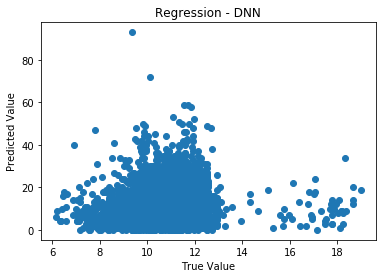

In [156]:
plt.plot(pred, target_test, 'o')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Regression - DNN')
plt.show()

## Pred, True, Error table

In [157]:
pred1 = pred.reshape(6481,)

In [167]:
c = { 'y_true': target_test, 
     'y_pred': pred1.round(), 
     #'error': target_test - pred1.round()}
    }
pred_diff = pd.DataFrame(data=c).reset_index()
pred_diff = pred_diff.drop(['index'], axis=1).reset_index(drop=True)
pred_diff.tail()

,y_pred,y_true
6476,11.0,11
6477,12.0,17
6478,12.0,16
6479,10.0,15
6480,13.0,11


In [159]:
pred_diff.to_csv('A://workspace//AI_project//results//processed//lin_reg_dnn.csv', encoding='utf-8', index=False, line_terminator='\n')

## ==========================================

## OLS Estimation

In [160]:
# 데이터 로드
x_ols_raw = t_train_raw
target_ols = target_raw

# 정규화 적용
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x_ols_raw)
x_ols = pd.DataFrame(x_scaled)

# 일관성을 위한 코드
# shuffle과 random_seed 값 1004를 적용하여 일관성 있는 순서를 위해 아래 코드가 사용되었음:
x_ols, _, target_ols, _ = train_test_split(x_ols, target_ols, 
                                           test_size=0, 
                                           shuffle = True, 
                                           random_state = 1004)

colname = ['sex', 'intubed','age_grp','pneumonia',
            'pregnancy', 'diabetes', 'copd', 'asthma',
            'inmsupr','hypertension','other_disease',
            'cardiovascular','obesity', 'renal_chronic', 
            'tobacco', 'contact_other_covid', 'covid_res', 
            'icu']

x_ols = x_ols.reset_index(drop=True)
x_ols.columns = colname
target_ols = target_ols.reset_index(drop=True)

FD = sm.OLS(endog=target_ols,
            exog=x_ols).fit()
FD.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              diff_days   R-squared (uncentered):                   0.690
Model:                            OLS   Adj. R-squared (uncentered):              0.689
Method:                 Least Squares   F-statistic:                              3998.
Date:                Mon, 21 Sep 2020   Prob (F-statistic):                        0.00
Time:                        19:38:05   Log-Likelihood:                     -1.1086e+05
No. Observations:               32402   AIC:                                  2.218e+05
Df Residuals:                   32384   BIC:                                  2.219e+05
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
sex                     0.3519      0.088      4.006      0.000       0.180       0.524
intubed                -1.9781      0.265     -7.454      0.000      -2.498      -1.458
age_grp                -0.1157      0.211     -0.548      0.584      -0.530       0.298
pneumonia              -0.3655      0.101     -3.629      0.000      -0.563      -0.168
pregnancy              21.8594      0.712     30.689      0.000      20.463      23.256
diabetes                1.0747      0.180      5.977      0.000       0.722       1.427
copd                    1.0203      0.356      2.865      0.004       0.322       1.718
asthma                 -1.1892      0.531     -2.240      0.025      -2.230      -0.148
inmsupr                 1.0660      0.419      2.544      0.011       0.245       1.887
hypertension            0.0446      0.183      0.243      0.808      -0.314       0.404
other_disease           0.3460      0.325      1.065      0.287      -0.291       0.983
cardiovascular          1.0148      0.341      2.972      0.003       0.346       1.684
obesity                 0.1060      0.196      0.541      0.589      -0.278       0.490
renal_chronic           2.1095      0.311      6.776      0.000       1.499       2.720
tobacco                -0.8251      0.282     -2.929      0.003      -1.377      -0.273
contact_other_covid     0.7989      0.139      5.763      0.000       0.527       1.071
covid_res              -2.5672      0.147    -17.450      0.000      -2.856      -2.279
icu                    -3.3982      0.298    -11.418      0.000      -3.982      -2.815
==============================================================================
Omnibus:                    11619.412   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58642.288
Skew:                           1.668   Prob(JB):                         0.00
Kurtosis:                       8.684   Cond. No.                         37.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- 부연설명:
- R-squared (uncentered):	0.690 으로 약 69% 모델 적합도
- x 값이 1 증가할때 마다 해당 coef 만큼 y 값 변동
- 즉 폐렴(pneumonia)가 1 증가 ( 1 : 예 -> 2: 아니오 ) 하면 예상 사망일이 -.3655일 만큼 짧아짐
- 임신 (pregnancy)가 아닐수록 (1 -> 2) 예상 사망일이 21.85일 만큼 길어짐
- 남자 (sex : 2) 일수록 예상 사망일이 0.35일 늘어남 등

### Classification_report

In [161]:
pred2 = FD.predict(x_ols)
rmse1 = np.sqrt(mean_squared_error(target_ols, pred2))
mse1 = mean_squared_error(target_ols, pred2)

print("MSE: ", mse1, "RMSE: ", rmse1)

MSE:  54.85987560071798 RMSE:  7.406745277159056


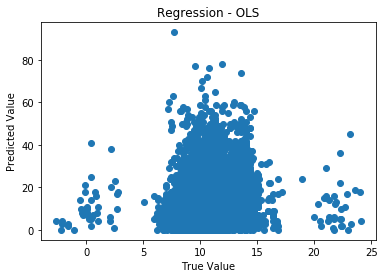

In [162]:
plt.plot(pred2, target_ols, 'o')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Regression - OLS')
plt.show()

## Predicted, True, Error table

In [163]:
d = { 'y_true': target_ols, 
      'y_pred': pred2.round(), 
      #'error': target_ols - pred2.round()}
    }

pred_diff1 = pd.DataFrame(data=d).reset_index()
pred_diff1 = pred_diff1.drop(['index'], axis=1)

In [166]:
pred_diff1.tail()

,y_pred,y_true
32397,12.0,12
32398,10.0,16
32399,10.0,3
32400,11.0,8
32401,12.0,8


In [165]:
pred_diff1.to_csv('A://workspace//AI_project//results//processed//lin_reg_ols.csv', encoding='utf-8', index=False, line_terminator='\n')

- 참고로 OLS는 train/test 를 구분하지 않기 때문에 csv에 모든 예측 결과값이 저장됨
- 총 32402개의 데이터가 입력되었음